# Bayesian Linear Regressionの実装

## サンプルデータの生成

以下のようなモデルからデータを生成する：
$$
t = \sin(x) + 0.5 \sin(2x) + 0.1x + 0.4 \epsilon \\
\epsilon \sim \mathcal{N}(0, 1)
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 今回予測対象とするモデル
def model_func(x):
    return np.sin(x) + 0.5*np.sin(x*2.0) + 0.1*x

# xのn次までを使った重線形回帰を想定
def feature_matrix(x, n):
    return np.stack([x**n for n in range(n)], 1)
    
# パラメータの設定
N = 50 # データのサンプル数
std_error_t = 0.4 # エラーの標準偏差
n_dim = 10 # 重線形回帰の次元

# データの生成
x = (np.random.uniform(size = N) * 2.0 - 1.0) * np.pi # [-pi, pi]から一様乱数を生成
t = model_func(x) + std_error_t*np.random.normal(size = N) # 実測データにはノイズを乗せる
X = feature_matrix(x, n_dim) # 特徴量行列
pd.DataFrame(data = X) # 特徴量行列の形を確認

,0,1,2,3,4,5,6,7,8,9
0,1.0,2.597022,6.744523,17.515674,4.548859e+01,1.181349e+02,3.067989e+02,7.967634e+02,2.069212e+03,5.373789e+03
1,1.0,2.349741,5.521282,12.973583,3.048456e+01,7.163081e+01,1.683139e+02,3.954940e+02,9.293083e+02,2.183634e+03
2,1.0,-1.815934,3.297615,-5.988249,1.087426e+01,-1.974694e+01,3.585913e+01,-6.511779e+01,1.182496e+02,-2.147334e+02
3,1.0,0.749034,0.561052,0.420247,3.147795e-01,2.357806e-01,1.766077e-01,1.322852e-01,9.908612e-02,7.421888e-02
4,1.0,-0.960060,0.921716,-0.884902,8.495596e-01,-8.156284e-01,7.830523e-01,-7.517774e-01,7.217515e-01,-6.929249e-01
5,1.0,-0.830606,0.689906,-0.573040,4.759699e-01,-3.953433e-01,3.283743e-01,-2.727496e-01,2.265473e-01,-1.881715e-01
6,1.0,2.966781,8.801789,26.112982,7.747150e+01,2.298410e+02,6.818878e+02,2.023012e+03,6.001833e+03,1.780612e+04
7,1.0,-0.029518,0.000871,-0.000026,7.591786e-07,-2.240939e-08,6.614788e-10,-1.952549e-11,5.763522e-13,-1.701273e-14
8,1.0,-1.787279,3.194366,-5.709224,1.020398e+01,-1.823735e+01,3.259524e+01,-5.825678e+01,1.041211e+02,-1.860935e+02
9,1.0,2.135614,4.560847,9.740210,2.080133e+01,4.442361e+01,9.487168e+01,2.026093e+02,4.326953e+02,9.240701e+02


データの様子をプロット

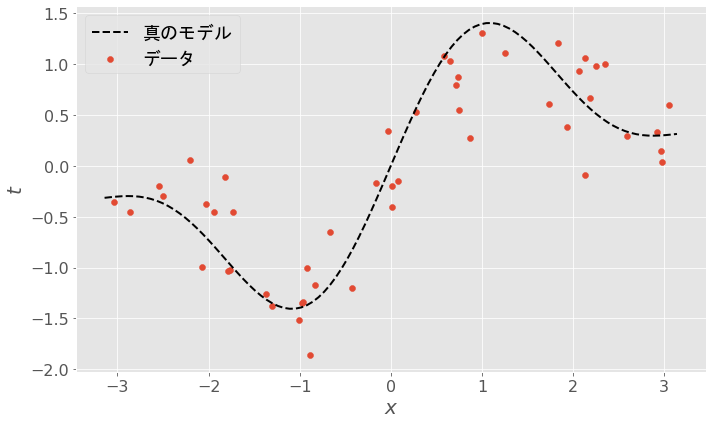

In [2]:
# 真のモデルを表すデータ
x_grid = np.linspace(-np.pi, np.pi, 100) # グリッドで刻む
t_grid = model_func(x_grid) # 真のモデル
X_grid = feature_matrix(x_grid, n_dim) # モデルの予測値を表すために必要

# グラフの設定
plt.style.use("ggplot")
fig = plt.figure(figsize = (10, 6), tight_layout = True)
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(r"$x$", size = 20)
ax.set_ylabel(r"$t$", size = 20)
ax.tick_params(labelsize = 16) # 目盛ラベルのサイズ

# データのプロット
ax.scatter(x, t, label = "データ")
ax.plot(x_grid, t_grid, color = "black", linewidth = 2.0, linestyle = "--", label = "真のモデル")
ax.legend(prop = {"family": "MS Gothic", "size": 18}) # 凡例に日本語を使うため
fig.savefig("model.jpg")

## ベイジアン線形回帰
以下の記事を参照して，ベイズ線形回帰のクラスを作成．
https://qiita.com/amber_kshz/items/35bf3ef761e4d3b248b3

In [3]:
class Bayesian_Linear_Regression:
    def __init__(self, alpha = 1.0, beta = 1.0):
        # ハイパーパラメータ
        self.alpha = alpha
        self.beta = beta
        self.m_vec = None # 事後分布での重みパラメータwの期待値
        self.S = None # 事後分布での重みパラメータwの共分散行列
        
    def calc_posterior_params(self, Phi, t):
        self.S = np.linalg.inv(self.alpha*np.identity(len(Phi[0])) + self.beta*(Phi.T)@Phi )
        self.m_vec = self.beta * ( self.S @ (Phi.T) @ t)
        
    def predict(self, Phi, return_std = False):
        pred_mean = Phi @ self.m_vec
        if not(return_std):
            return pred_mean
        else:
            pred_std = np.sqrt(1.0/self.beta + np.diag(Phi @ self.S @ (Phi.T) ) )
            return pred_mean, pred_std
        
    def calc_evidence(self, Phi, t):
        N, M = np.shape(Phi)
        self.calc_posterior_params(Phi, t)
        
        evidence = 0.5*M*np.log(self.alpha) + 0.5*N*np.log(self.beta) \
            - 0.5*self.beta*np.linalg.norm(t - Phi@self.m_vec)**2 - 0.5*self.alpha*(self.m_vec@self.m_vec) \
            - 0.5*np.log( np.linalg.det(self.alpha*np.identity(M) + self.beta*(Phi.T)@Phi) ) \
            - 0.5*N*np.log(2*np.pi)
        return evidence
        
    def empirical_bayes(self, Phi, t, tol, maxiter, show_message=True):
        tmp_lambdas = np.linalg.eigh((Phi.T)@Phi)[0]
        cnt = 0
        while cnt < maxiter:
            lambdas = self.beta * tmp_lambdas
            self.calc_posterior_params(Phi, t)

            alpha_old = self.alpha
            beta_old = self.beta

            gamma = np.sum( lambdas/ (self.alpha + lambdas) )
            self.alpha = gamma/np.dot(self.m_vec, self.m_vec)
            self.beta = (len(t) - gamma) / ( np.linalg.norm(t -  Phi @ self.m_vec)**2    )
            if (abs(self.alpha - alpha_old) < tol) and ( abs(self.beta - beta_old) < tol ):
                break
            cnt += 1
        
        self.calc_posterior_params(Phi, t) # もう一度事後分布に基づいて計算しておく
        
        if show_message:
            if cnt <= maxiter:
                print(f"Optimization terminated succesfully. The number of iteration : {cnt}")
            else:
                print("Maximum number of iteration exceeded.")
    
    def calc_score(self, Phi_test, t_test):
        # 事後分布はすでに求めている必要がある
        t_pred = self.predict(Phi_test, return_std = False)
        score = self.calc_R2(t_pred, t_test) # 一般にエビデンスは計算できないため，決定係数を用いる
        return score
    
    def calc_R2(self, t_pred, t_test): # 決定係数を算出
        u = ((t_test - t_pred)**2).sum()
        v = ((t_test - t_test.mean())**2).sum()
        return 1.0 - u/v
    
    def calc_loss_func(self, t_pred, t_test): # Bayes線形回帰と等価なRidge回帰の目的関数
        return -0.5 * self.beta * ((t_test - t_pred)**2.0).sum() - 0.5 * self.alpha * (self.m_vec**2.0).sum()


エビデンス最適化によりハイパーパラメータを算出

In [4]:
model = Bayesian_Linear_Regression()
model.empirical_bayes(X, t, tol = 1e-5, maxiter = 100) # エビデンス最適化
alpha_optimal, beta_optimal = model.alpha, model.beta
print("Optimal Value: alpha = {0:.3f}, beta = {1:.3f}".format(alpha_optimal, beta_optimal))

Optimization terminated succesfully. The number of iteration : 16
Optimal Value: alpha = 4.741, beta = 7.662


等高線と最適化されたモデルのプロット

Optimization terminated succesfully. The number of iteration : 13


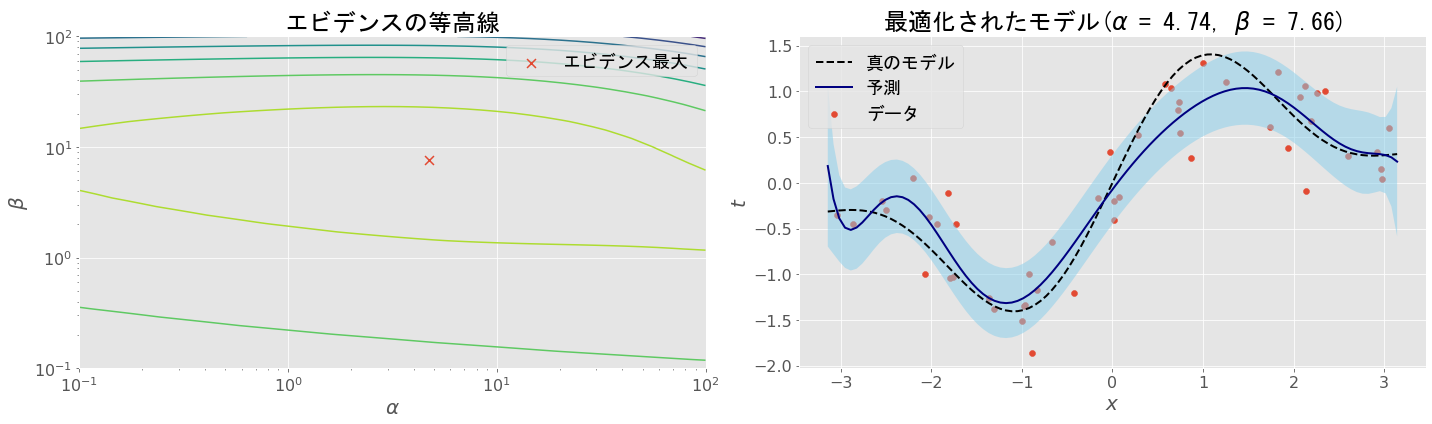

In [5]:
# ハイパーパラメータの範囲
alpha_min, alpha_max, alpha_bin = 0.1, 100.0, 40
beta_min, beta_max, beta_bin = 0.1, 100.0, 40
# ハイパーパラメータの組合わせを指数刻みで作成
alpha_list = np.geomspace(alpha_min, alpha_max, alpha_bin)
beta_list = np.geomspace(beta_min, beta_max, beta_bin)
Alpha_list, Beta_list = np.meshgrid(alpha_list, beta_list) # プロットのためにメッシュを作成
Evidence_list = np.zeros(Alpha_list.shape) # 計算したエビデンスを格納するリスト

for idx1 in range(len(alpha_list)): # 面倒なのでforループで実装
    for idx2 in range(len(beta_list)):
        alpha = Alpha_list[idx2, idx1] # ラベルの順に注意
        beta = Beta_list[idx2, idx1]
        model = Bayesian_Linear_Regression(alpha, beta)
        Evidence_list[idx2, idx1] = model.calc_evidence(X, t)
        
fig = plt.figure(figsize = (20, 6), tight_layout = True)
# 等高線のプロット
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel(r"$\alpha$", size = 20)
ax.set_ylabel(r"$\beta$", size = 20)
ax.tick_params(labelsize = 16)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(r"エビデンスの等高線", fontsize = 24, fontname = "MS Gothic")
ax.contour(Alpha_list, Beta_list, Evidence_list) # 等高線
ax.scatter(alpha_optimal, beta_optimal, label = "エビデンス最大", marker = "x", s = 80) # 最適な点
ax.legend(prop = {"family": "MS Gothic", "size": 18})

# 最適化されたモデルのプロット
ax = fig.add_subplot(1, 2, 2)
model.empirical_bayes(X, t, tol = 1e-4, maxiter = 100)
t_pred, t_std = model.predict(X_grid, return_std = True)
ax.set_xlabel(r"$x$", size = 20)
ax.set_ylabel(r"$t$", size = 20)
ax.tick_params(labelsize = 16)
ax.set_title(r"最適化されたモデル($\alpha$ = {0:.2f}, $\beta$ = {1:.2f})".format(alpha_optimal, beta_optimal),\
             fontsize = 24, fontname = "MS Gothic")
ax.scatter(x, t, label = "データ")
ax.plot(x_grid, t_grid, color = "black", linewidth = 2.0, linestyle = "--", label = "真のモデル")
ax.plot(x_grid, t_pred, color = "navy", linewidth = 2.0, linestyle = "-", label = "予測")
ax.fill_between(x_grid, t_pred-t_std, t_pred+t_std, facecolor = "skyblue", alpha = 0.5)
ax.legend(prop = {"family": "MS Gothic", "size": 18})

fig.savefig("evidence_optimized.jpg")

エビデンスがあらわに計算できないと仮定するため，訓練データとテストデータに分割する．

In [6]:
train_ratio = 0.6 # 訓練データの比率
N_train = int(N * train_ratio)
N_test = N - N_train
# 訓練データとテストデータに分割
X_train, X_test = X[0: N_train], X[N_train: ]
t_train, t_test = t[0: N_train], t[N_train: ]

ハイパーパラメータの組$\Theta$を作成

In [7]:
import itertools # ハイパーパラメータの組み合わせを生成するために使用
df_params = pd.DataFrame(list(itertools.product(alpha_list, beta_list)), columns = ["alpha", "beta"])
df_params["score"] = np.nan
display(df_params) # どのような形になっているか確認

,alpha,beta,score
0,0.1,0.100000,NaN
1,0.1,0.119378,NaN
2,0.1,0.142510,NaN
3,0.1,0.170125,NaN
4,0.1,0.203092,NaN
...,...,...,...
1595,100.0,49.238826,NaN
1596,100.0,58.780161,NaN
1597,100.0,70.170383,NaN
1598,100.0,83.767764,NaN


ガウス過程回帰の実装

In [8]:
from sklearn.gaussian_process import *
kernel = kernels.RBF(1.0, (3e-1, 1e3)) + kernels.ConstantKernel(1.0, (3e-1, 1e3)) + kernels.WhiteKernel()
model_hyper_param = GaussianProcessRegressor(
    kernel = kernel,
    alpha = 1e-3,
    optimizer = "fmin_l_bfgs_b",
    n_restarts_optimizer = 20,
    normalize_y = True)

In [9]:
# スコアを算出しているdf_params_w_scoreをもとにガウス過程回帰し，df_to_append_ucbにUCBを追加する(対数変換に注意)
def upper_confidence_bound(df_params_w_score, df_to_append_ucb):
    # Gauss過程回帰の学習
    x_hyper_param_train = np.log(df_params_w_score.values[:, :-1]) # スコア以外を対数変換
    y_hyper_param_train = df_params_w_score[["score"]].values
    model_hyper_param.fit(x_hyper_param_train, y_hyper_param_train) # ガウス過程回帰
    # Gauss過程回帰の予測
    x_hyper_param_test = np.log(df_to_append_ucb.values[:, :-1]) # スコア以外を対数変換
    score_pred, score_std = model_hyper_param.predict(x_hyper_param_test, return_std = True)
    score_pred = score_pred[:, 0] # 変な形になっているため，修正
    # スコアがわかっていないサンプルに対してUCBをくっつける
    df_to_append_ucb["UCB"] = score_pred + np.sqrt(np.log(len(df_params_w_score))/len(df_params_w_score)) * score_std
    return df_to_append_ucb
    

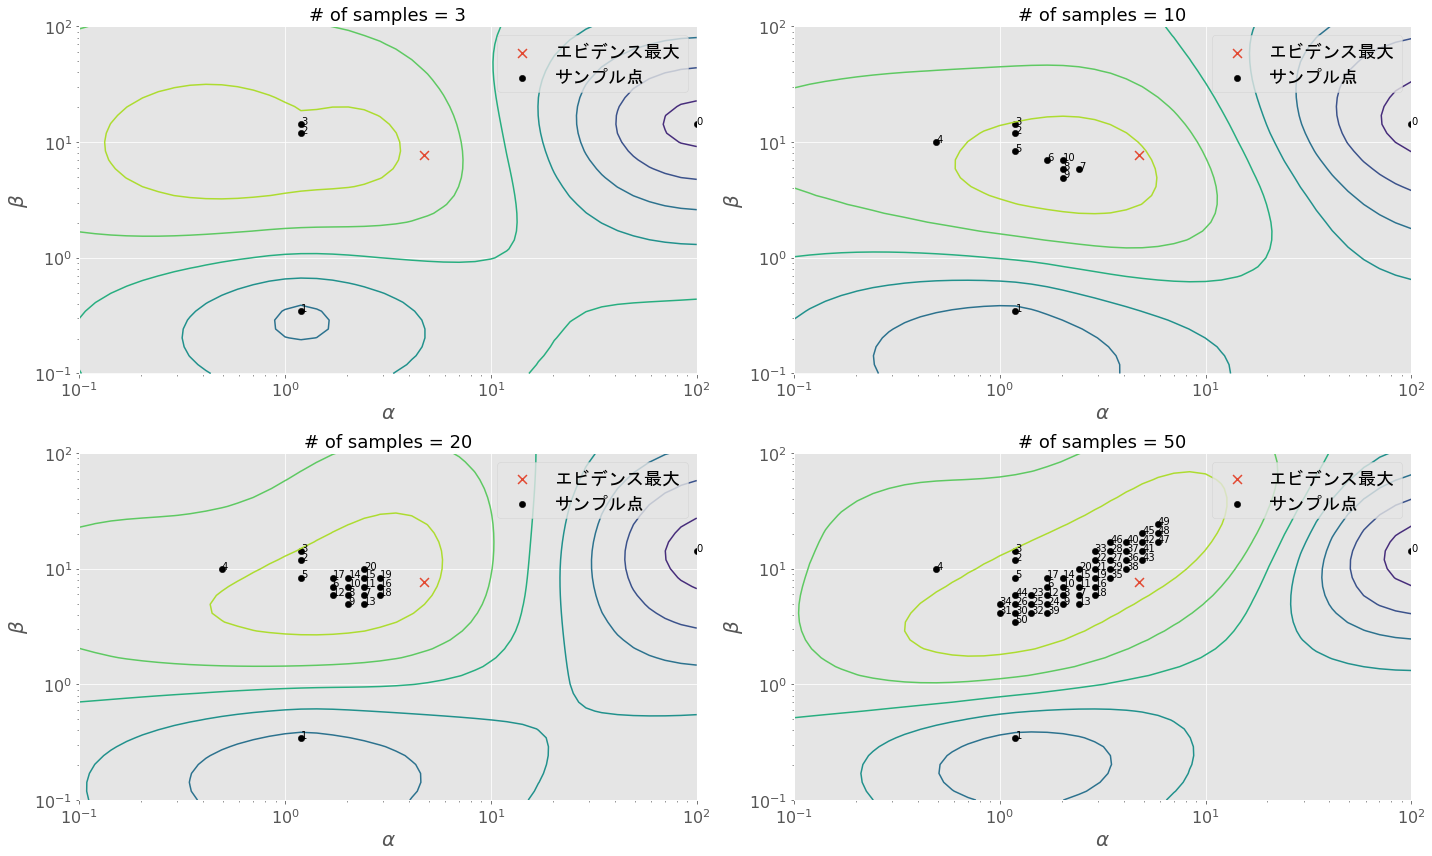

In [10]:
n_sample = 50 # 探索するハイパーパラメータの数
n_sample_for_GR = 3 # Gaussian Regressionのために必要とする，事前のハイパーパラメータ探索数
sample_list_for_snapshot = [n_sample_for_GR, 10, 20, n_sample] # グラフに出力するタイミング

df_params = pd.DataFrame(list(itertools.product(alpha_list, beta_list)), columns = ["alpha", "beta"])
df_params["score"] = np.nan
df_params_for_labels = pd.DataFrame(columns = ["alpha", "beta"]) # プロット用のデータフレーム

# グラフの設定
idx_plot = 1
fig = plt.figure(figsize = (20, 12), tight_layout = True)

for s in range(n_sample + 1):
    print("sample = {}".format(s), end = "\r")
    idx_score_nan = df_params[df_params["score"].isnull()].index # 未探索の箇所
    
    if s < n_sample_for_GR: # 試行回数がGauss過程回帰に十分でないとき
        idx_sample = np.random.choice(idx_score_nan)
    else:
        # スコアが分かっているサンプルとわかっていないものに分割
        df_params_w_score = df_params[~(df_params["score"].isnull())].copy() # スコアがわかっているサンプル
        df_params_wo_score = df_params[df_params["score"].isnull()].copy() # スコアがわかっていないサンプル
        df_params_wo_score = upper_confidence_bound(df_params_w_score, df_params_wo_score) # UCBを追加
        idx_sample = df_params_wo_score.sort_values(by = "UCB", ascending = False).index.values[0]
    
    # 探索すべきパラメータ
    alpha, beta, _ = df_params.iloc[idx_sample].values # scoreはいらないので捨てる
    df_params_for_labels.loc[s] = [alpha, beta] # プロット用のデータフレームに格納
    model = Bayesian_Linear_Regression(alpha = alpha, beta = beta) # ベイズ線形回帰
    model.calc_posterior_params(X_train, t_train) # ハイパーパラメータをもとに最適化
    df_params.at[idx_sample, "score"] = model.calc_score(X_test, t_test) # 予測値に基づいてスコア算出
    
    # sが特定の値の場合はスナップショット(本質的にここは不要)
    if s in sample_list_for_snapshot:
        df_params_w_score = df_params[~(df_params["score"].isnull())].copy() # スコアがわかっているサンプル
        df_params_ucb = df_params.copy()
        df_params_ucb = upper_confidence_bound(df_params_w_score, df_params_ucb)
        # pivotによっていい感じに変形
        Evidence_list = df_params_ucb.pivot(index = "beta", columns = "alpha", values = "UCB").values
        
        # プロットを作成
        ax = fig.add_subplot(2, 2, idx_plot)
        ax.set_xlabel(r"$\alpha$", size = 20)
        ax.set_ylabel(r"$\beta$", size = 20)
        ax.tick_params(labelsize = 16)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title("# of samples = {}".format(s), fontsize = 18)
        
        ax.contour(Alpha_list, Beta_list, Evidence_list)
        ax.scatter(alpha_optimal, beta_optimal, label = "エビデンス最大", marker = "x", s = 80) # 最適な点
        ax.scatter(df_params_w_score["alpha"], df_params_w_score["beta"], label = "サンプル点", s = 40, c = "black")
        for idx in df_params_for_labels.index:
            ax.annotate(idx, (df_params_for_labels.at[idx, "alpha"], df_params_for_labels.at[idx, "beta"]))
        ax.legend(prop = {"family": "MS Gothic", "size": 18})
        
        idx_plot += 1 # プロット位置

fig.savefig("hyper_param.jpg")

ハイパーパラメータの組に対して，スコアがどのようになっているか確認．

In [11]:
df_params.sort_values(by = "score", ascending = False)

,alpha,beta,score
663,1.701254,5.878016,0.808443
909,4.923883,17.012543,0.808443
786,2.894266,10.000000,0.808443
950,5.878016,20.309176,0.808443
827,3.455107,11.937766,0.808443
...,...,...,...
1595,100.000000,49.238826,NaN
1596,100.000000,58.780161,NaN
1597,100.000000,70.170383,NaN
1598,100.000000,83.767764,NaN


ハイパーパラメータ調整初期の予測

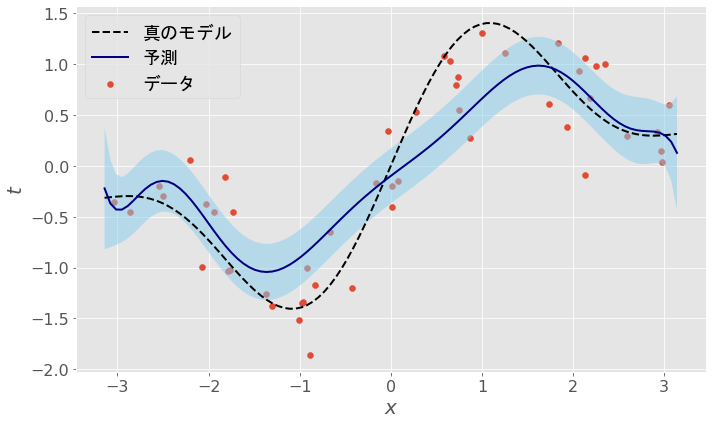

In [12]:
alpha, beta = df_params_for_labels.loc[0].values
model = Bayesian_Linear_Regression(alpha, beta)
model.calc_posterior_params(X, t)
t_pred, t_std = model.predict(X_grid, return_std = True)
fig = plt.figure(figsize = (10, 6), tight_layout = True)
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(r"$x$", size = 20)
ax.set_ylabel(r"$t$", size = 20)
ax.tick_params(labelsize = 16)

# データのプロット
ax.scatter(x, t, label = "データ")
ax.plot(x_grid, t_grid, color = "black", linewidth = 2.0, linestyle = "--", label = "真のモデル")
ax.plot(x_grid, t_pred, color = "navy", linewidth = 2.0, linestyle = "-", label = "予測")
ax.fill_between(x_grid, t_pred-t_std, t_pred+t_std, facecolor = "skyblue", alpha = 0.5)
ax.legend(prop = {"family": "MS Gothic", "size": 18})
fig.savefig("model_initial.jpg")

学習最終段階の予測

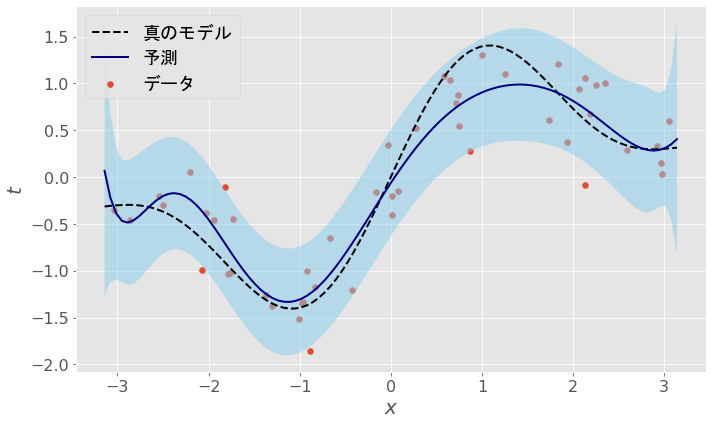

In [13]:
alpha, beta = df_params_for_labels.loc[n_sample].values
model = Bayesian_Linear_Regression(alpha, beta)
model.calc_posterior_params(X, t)
t_pred, t_std = model.predict(X_grid, return_std = True)
fig = plt.figure(figsize = (10, 6), tight_layout = True)
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(r"$x$", size = 20)
ax.set_ylabel(r"$t$", size = 20)
ax.tick_params(labelsize = 16)

# データのプロット
ax.scatter(x, t, label = "データ")
ax.plot(x_grid, t_grid, color = "black", linewidth = 2.0, linestyle = "--", label = "真のモデル")
ax.plot(x_grid, t_pred, color = "navy", linewidth = 2.0, linestyle = "-", label = "予測")
ax.fill_between(x_grid, t_pred-t_std, t_pred+t_std, facecolor = "skyblue", alpha = 0.5)
ax.legend(prop = {"family": "MS Gothic", "size": 18})
fig.savefig("model_tuned.jpg")

ハイパーパラメータごとにグラフを作成

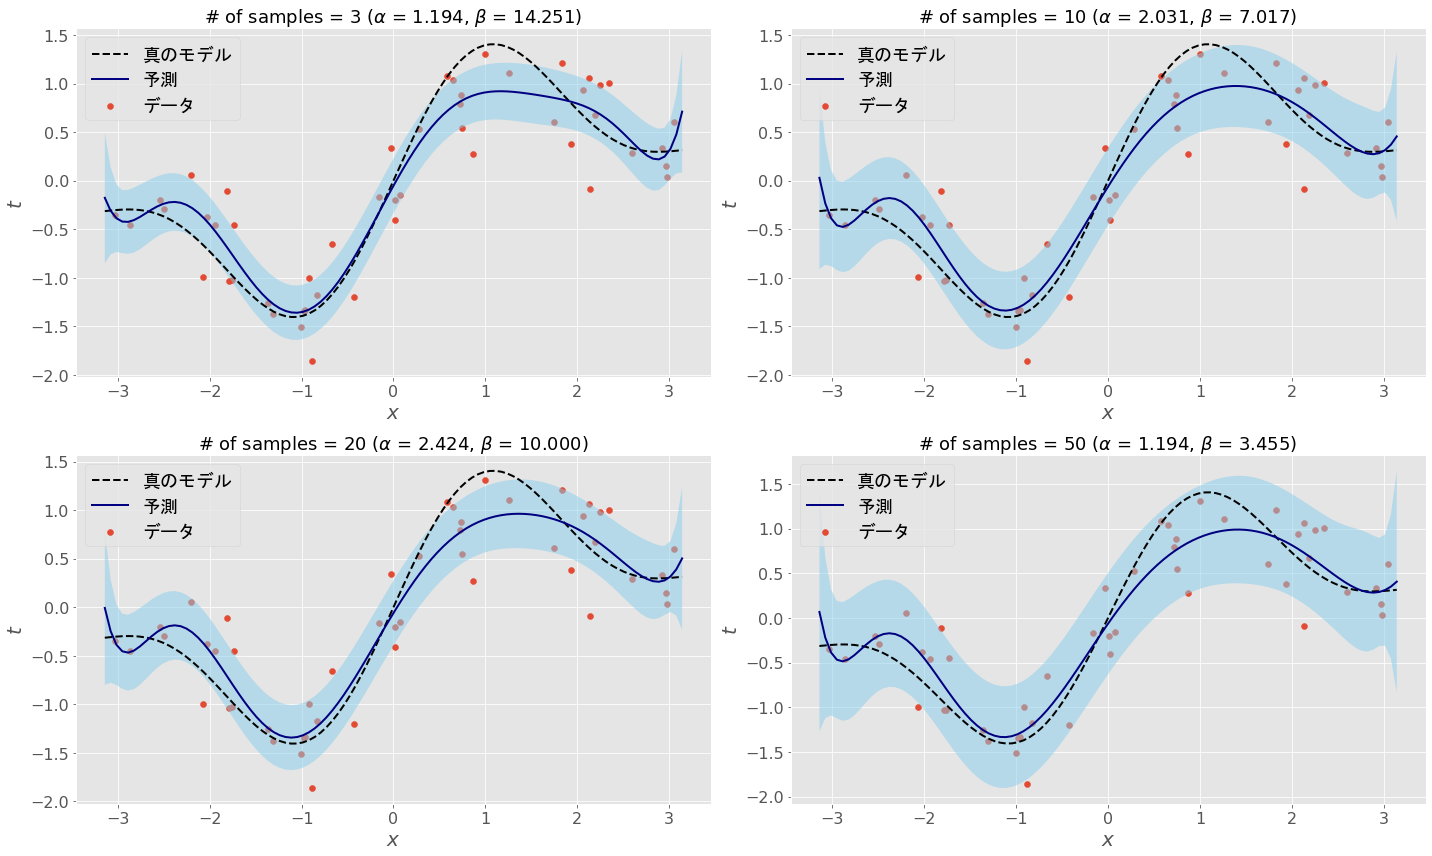

In [14]:
fig = plt.figure(figsize = (20, 12), tight_layout = True)
idx_plot = 1

for s in sample_list_for_snapshot:
    alpha, beta = df_params_for_labels.loc[s].values
    model = Bayesian_Linear_Regression(alpha, beta)
    model.calc_posterior_params(X, t)
    t_pred, t_std = model.predict(X_grid, return_std = True)
    
    ax = fig.add_subplot(2, 2, idx_plot)
    ax.set_xlabel(r"$x$", size = 20)
    ax.set_ylabel(r"$t$", size = 20)
    ax.tick_params(labelsize = 16)

    # データのプロット
    ax.scatter(x, t, label = "データ")
    ax.plot(x_grid, t_grid, color = "black", linewidth = 2.0, linestyle = "--", label = "真のモデル")
    ax.plot(x_grid, t_pred, color = "navy", linewidth = 2.0, linestyle = "-", label = "予測")
    ax.fill_between(x_grid, t_pred-t_std, t_pred+t_std, facecolor = "skyblue", alpha = 0.5)
    ax.legend(prop = {"family": "MS Gothic", "size": 18})
    ax.set_title(r"# of samples = {0:} ($\alpha$ = {1:.3f}, $\beta$ = {2:.3f})".format(s, alpha, beta), fontsize = 18)
    
    idx_plot += 1
fig.savefig("models_during_tuning.jpg")